<a href="https://colab.research.google.com/github/helenaortizz/TFM/blob/main/MODELO_PREDICTIVO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TFM: MODELO PREDICTIVO DE PARTO PRETÉRMINO

## 1. Importación de librerías y preparación del entorno

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import shap
import joblib

In [2]:
# Estilo unificado para los gráficos
sns.set(style='whitegrid')

In [3]:
# Cargar el dataset
file_path = '/content/drive/MyDrive/parto_pretermino_dataset.csv'
df = pd.read_csv(file_path)

# Análisis de valores únicos en variables categóricas
categorical_cols = ['Gestational_Diabetes', 'Gestational_Hypertension',
                    'Previous_Preterm_Birth','Previous_Cesarean',
                    'Chorioamnionitis', 'Mother_Age', 'Mother_Race',
                    'Mother_Education', 'Total_Birth_Order',
                    'Prenatal_Care_Start', 'BMI', 'No_Risk_Factors',
                    'No_Infections', 'Fetal_Presentation',
                    'Plurality', 'Gestation_Weeks']
# Definir mapeos para variables categóricas
age_mapping = {1: '<15', 2: '15-19', 3: '20-24', 4: '25-29', 5: '30-34',
               6: '35-39', 7: '40-44', 8: '45-49', 9: '50-54'}
race_mapping = {1: 'White', 2: 'Black', 3: 'AIAN', 4: 'Asian', 5: 'NHOPI', 6: 'Multiracial'}
education_mapping = {1: '≤8th', 2: '9-12_no_diploma', 3: 'HS_diploma', 4: 'Some_college'}
bmi_mapping = {1: 'Underweight', 2: 'Normal', 3: 'Overweight', 4: 'Obesity_I',
               5: 'Obesity_II', 6: 'Extreme_Obesity', 9: 'Unknown'}
# Eliminación de "U" de "unknown" para convertir en binarios
binary_mapping = {'Y': 1, 'N': 0}

# Aplicación de las conversiones
df['Mother_Age'] = df['Mother_Age'].map(age_mapping)
df['Mother_Race'] = df['Mother_Race'].map(race_mapping)
df['Mother_Education'] = df['Mother_Education'].map(education_mapping)
df['BMI'] = df['BMI'].map(bmi_mapping)

# Conversión en variables binarias de cara a entrenar el modelo de ML
binary_cols = ['Gestational_Diabetes', 'Gestational_Hypertension', 'Previous_Preterm_Birth',
               'Previous_Cesarean', 'Chorioamnionitis']

for col in binary_cols:
    df[col] = df[col].map(binary_mapping)

# Conversión a category para hacer mayor eficiencia
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Imputación de valores nulos en 'Mother_Education' con la moda o 'Unknown'
# en caso de no poder o no estar definida
if df['Mother_Education'].mode().empty:
    df['Mother_Education'] = df['Mother_Education'].fillna("Unknown")
else:
    df['Mother_Education'] = df['Mother_Education'].fillna(df['Mother_Education'].mode()[0])

# Imputaciñon devariables binarias con la moda (para evitar problemas con NaN)
# Se asigna 0 si la moda no está definida
for col in binary_cols:
    if df[col].mode().empty:
        df[col] = df[col].fillna(0)
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Eliminación de filas con más de 2 valores nulos
df_clean = df.dropna(thresh=len(df.columns) - 2)

# Conversión de la la variable objetivo
gestation_mapping = {1: 1, 2: 0, 3: None}
df_clean['Gestation_Weeks'] = df_clean['Gestation_Weeks'].map(gestation_mapping)

# Eliminación de filas con valor desconocido si existen
df_clean = df_clean.dropna(subset=['Gestation_Weeks'])

# Verificación de la distribución de la variable objetivo
print('\nDistribución de la variable objetivo:')
print(df_clean['Gestation_Weeks'].value_counts(normalize=True))


Distribución de la variable objetivo:
Gestation_Weeks
0.0    0.877667
1.0    0.122333
Name: proportion, dtype: float64


## 2. Preprocesamiento de los datos

### 2.1. One Hot Encoding

In [4]:
# Aplicación de one hot encoding a todas las variables categóricas
df_encoded = pd.get_dummies(df_clean, drop_first=True, dtype=int)

# Verificación de la transformación y visualización de las primeras filas
print(df_encoded.dtypes)
print(df_encoded.head())

Interval_Last_Pregnancy            int64
Smoking_Before_Pregnancy           int64
Gestation_Weeks                  float64
Mother_Age_20-24                   int64
Mother_Age_25-29                   int64
Mother_Age_30-34                   int64
Mother_Age_35-39                   int64
Mother_Age_40-44                   int64
Mother_Age_45-49                   int64
Mother_Age_50-54                   int64
Mother_Age_<15                     int64
Mother_Race_Asian                  int64
Mother_Race_Black                  int64
Mother_Race_Multiracial            int64
Mother_Race_NHOPI                  int64
Mother_Race_White                  int64
Mother_Education_HS_diploma        int64
Mother_Education_Some_college      int64
Mother_Education_≤8th              int64
Total_Birth_Order_2                int64
Total_Birth_Order_3                int64
Total_Birth_Order_4                int64
Total_Birth_Order_5                int64
Total_Birth_Order_6                int64
Total_Birth_Orde

### 2.2. Escalado de variables numéricas

In [5]:
# Escalado de las variabes numéricas
# Separación de las variables numéricas
num_cols = ['Interval_Last_Pregnancy', 'Smoking_Before_Pregnancy']

# Inciciar el escalador
scaler = StandardScaler()

# Aplicación del escalado solo a las variables numéricas
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# Verificar resultado
print(df_encoded.head())

   Interval_Last_Pregnancy  Smoking_Before_Pregnancy  Gestation_Weeks  \
0                -1.902163                 -0.179448              0.0   
1                -2.079188                 -0.179448              0.0   
2                -2.079188                 -0.179448              0.0   
3                -2.079188                 -0.179448              0.0   
4                -1.990675                 -0.179448              0.0   

   Mother_Age_20-24  Mother_Age_25-29  Mother_Age_30-34  Mother_Age_35-39  \
0                 0                 0                 0                 1   
1                 0                 1                 0                 0   
2                 1                 0                 0                 0   
3                 1                 0                 0                 0   
4                 0                 0                 0                 1   

   Mother_Age_40-44  Mother_Age_45-49  Mother_Age_50-54  ...  \
0                 0               

## 3. División en `Train` y `Test`

In [6]:
# Definición de las variables predictoras y la variable objetivo
X = df_clean.drop(['Gestation_Weeks'], axis=1)
y = df_clean['Gestation_Weeks']

# División en conjunto de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

# Verificación del tamaño de los conjuntos
print(f'Forma de X_train: {X_train.shape}')
print(f'Forma de X_test: {X_test.shape}')
print(f'Proporción de partos pretérmino en train: {np.mean(y_train):.2f}')
print(f'Proporción de partos pretérmino en test: {np.mean(y_test):.2f}')

# Realizar One-Hot Encoding para las variables categóricas
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Asegurar que X_train y X_test tengan las mismas columnas tras la transformación
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Verificar la nueva forma de los datos después del encoding
print(f'Nueva forma de X_train: {X_train.shape}')
print(f'Nueva forma de X_test: {X_test.shape}')

Forma de X_train: (2521605, 17)
Forma de X_test: (1080688, 17)
Proporción de partos pretérmino en train: 0.12
Proporción de partos pretérmino en test: 0.12
Nueva forma de X_train: (2521605, 51)
Nueva forma de X_test: (1080688, 51)


## 4. MODELOS PREDICTIVOS

### 4.1. Regresión logística

In [7]:
# Creación y entrenamiento del modelo
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)

# Predicciones
y_pred_logreg = logreg.predict(X_test)

# Probabilidades para calcular AUC-ROC
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]

# Evaluación del modelo
print("\nModelo: Regresión Logística")
print('Matriz de confusión:\n', confusion_matrix(y_test, y_pred_logreg))
print('\nReporte de clasificación:\n', classification_report(y_test, y_pred_logreg))
print('\nAUC-ROC:', roc_auc_score(y_test, y_prob_logreg))


Modelo: Regresión Logística
Matriz de confusión:
 [[713620 234864]
 [ 59718  72486]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.92      0.75      0.83    948484
         1.0       0.24      0.55      0.33    132204

    accuracy                           0.73   1080688
   macro avg       0.58      0.65      0.58   1080688
weighted avg       0.84      0.73      0.77   1080688


AUC-ROC: 0.7036056660675194


### 4.2. Decision Trees

In [8]:
# Creación y entrenamiento del modelo
modelo_arbol = DecisionTreeClassifier(max_depth=10, random_state=42)
modelo_arbol.fit(X_train, y_train)

# Predicciones
y_pred_arbol = modelo_arbol.predict(X_test)
y_prob_arbol = modelo_arbol.predict_proba(X_test)[:, 1]

# Evaluación del modelo
print('\nModelo: Árbol de Decisión')
print('Matriz de confusión:\n', confusion_matrix(y_test, y_pred_arbol))
print('\nReporte de clasificación:\n', classification_report(y_test, y_pred_arbol))
print('\nAUC-ROC:', roc_auc_score(y_test, y_prob_arbol))


Modelo: Árbol de Decisión
Matriz de confusión:
 [[934929  13555]
 [112171  20033]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.94    948484
         1.0       0.60      0.15      0.24    132204

    accuracy                           0.88   1080688
   macro avg       0.74      0.57      0.59   1080688
weighted avg       0.86      0.88      0.85   1080688


AUC-ROC: 0.6960948387734971


### 4.3. Random Forest

In [9]:
# Creación y entrenamiento del modelo
modelo_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
modelo_rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = modelo_rf.predict(X_test)
y_prob_rf = modelo_rf.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva

# Evaluación del modelo
print('\nModelo: Random Forest')
print('Matriz de confusión:\n', confusion_matrix(y_test, y_pred_rf))
print('\nReporte de clasificación:\n', classification_report(y_test, y_pred_rf))
print('\nAUC-ROC:', roc_auc_score(y_test, y_prob_rf))


Modelo: Random Forest
Matriz de confusión:
 [[731076 217408]
 [ 62601  69603]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.92      0.77      0.84    948484
         1.0       0.24      0.53      0.33    132204

    accuracy                           0.74   1080688
   macro avg       0.58      0.65      0.59   1080688
weighted avg       0.84      0.74      0.78   1080688


AUC-ROC: 0.7011378738234688


### 4.4. XG BOOST

In [10]:
# Primero asegurar que los nombres de las columnas sean strings y eliminar
# caracteres potencialmente problemáticos
X_train.columns = X_train.columns.astype(str).str.replace(r"[<>\[\]\s]", "_", regex=True)
X_test.columns = X_test.columns.astype(str).str.replace(r"[<>\[\]\s]", "_", regex=True)

# Asegurar que ambas matrices tienen las mismas columnas
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# Cálculo la proporción de clases para ajustar el peso de la clase minoritaria
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Creación y entrenamiento del modelo
modelo_xgb = XGBClassifier(n_estimators=100, max_depth=10, random_state=42, scale_pos_weight=pos_weight)
modelo_xgb.fit(X_train, y_train)

# Predicciones
y_pred_xgb = modelo_xgb.predict(X_test)
y_prob_xgb = modelo_xgb.predict_proba(X_test)[:, 1]

# Evaluación del modelo
print('\nModelo: XGBoost')
print('Matriz de confusión:\n', confusion_matrix(y_test, y_pred_xgb))
print('\nReporte de clasificación:\n', classification_report(y_test, y_pred_xgb))
print('\nAUC-ROC:', roc_auc_score(y_test, y_prob_xgb))


Modelo: XGBoost
Matriz de confusión:
 [[714344 234140]
 [ 59963  72241]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.92      0.75      0.83    948484
         1.0       0.24      0.55      0.33    132204

    accuracy                           0.73   1080688
   macro avg       0.58      0.65      0.58   1080688
weighted avg       0.84      0.73      0.77   1080688


AUC-ROC: 0.7021685647204108


## 5. COMPARACIÓN DE LOS MODELOS

In [11]:
data = {
    'Modelo': ['Regresión Logística', 'Árbol de Decisión', 'Random Forest', 'XGBoost'],
    'Precisión (Parto a término)': [0.92, 0.89, 0.92, 0.92],
    'Recall (Parto pretérmino)': [0.55, 0.15, 0.53, 0.55],
    'F1-Score (Parto pretérmino)': [0.33, 0.24, 0.33, 0.33],
    'Exactitud (Accuracy)': [0.73, 0.88, 0.74, 0.73],
    'AUC-ROC': [0.70, 0.70, 0.70, 0.70]
}
df_comparativa = pd.DataFrame(data)
df_comparativa

,Modelo,Precisión (Parto a término),Recall (Parto pretérmino),F1-Score (Parto pretérmino),Exactitud (Accuracy),AUC-ROC
0,Regresión Logística,0.92,0.55,0.33,0.73,0.7
1,Árbol de Decisión,0.89,0.15,0.24,0.88,0.7
2,Random Forest,0.92,0.53,0.33,0.74,0.7
3,XGBoost,0.92,0.55,0.33,0.73,0.7


<Figure size 1200x600 with 0 Axes>

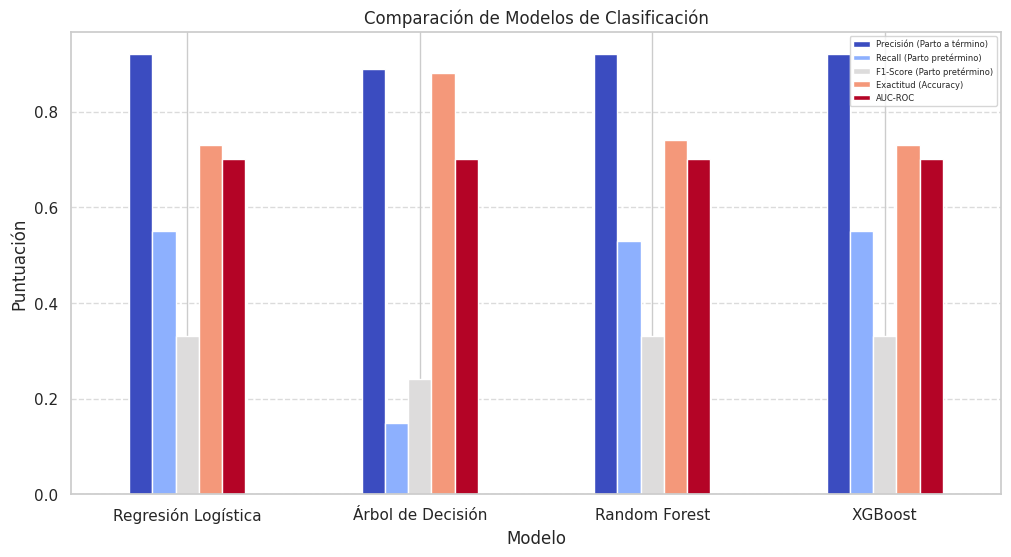

In [12]:
plt.figure(figsize=(12, 6))
df_comparativa.set_index("Modelo").plot(kind="bar", figsize=(12, 6), colormap="coolwarm")

plt.title("Comparación de Modelos de Clasificación")
plt.xticks(rotation=0)
plt.ylabel("Puntuación")
plt.legend(loc="upper right", fontsize="6")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

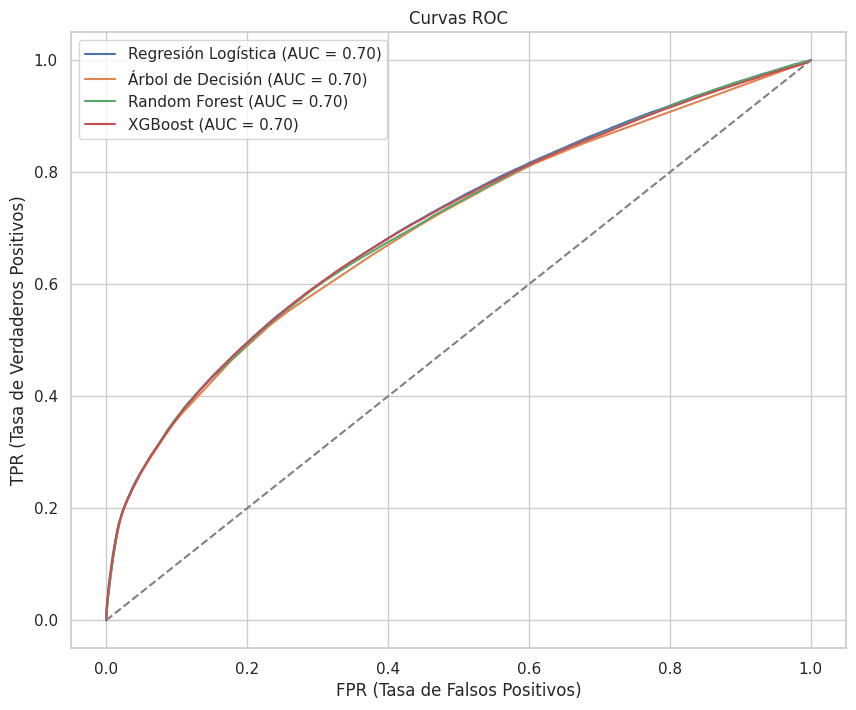

In [13]:
# Función para graficar las curvas ROC
def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc(fpr, tpr):.2f})')

plt.figure(figsize=(10, 8))

# Regresión Logística
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
plot_roc_curve(fpr_logreg, tpr_logreg, 'Regresión Logística')

# Árbol de Decisión
fpr_arbol, tpr_arbol, _ = roc_curve(y_test, y_prob_arbol)
plot_roc_curve(fpr_arbol, tpr_arbol, 'Árbol de Decisión')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plot_roc_curve(fpr_rf, tpr_rf, 'Random Forest')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plot_roc_curve(fpr_xgb, tpr_xgb, 'XGBoost')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Curvas ROC')
plt.xlabel('FPR (Tasa de Falsos Positivos)')
plt.ylabel('TPR (Tasa de Verdaderos Positivos)')
plt.legend()
plt.show()

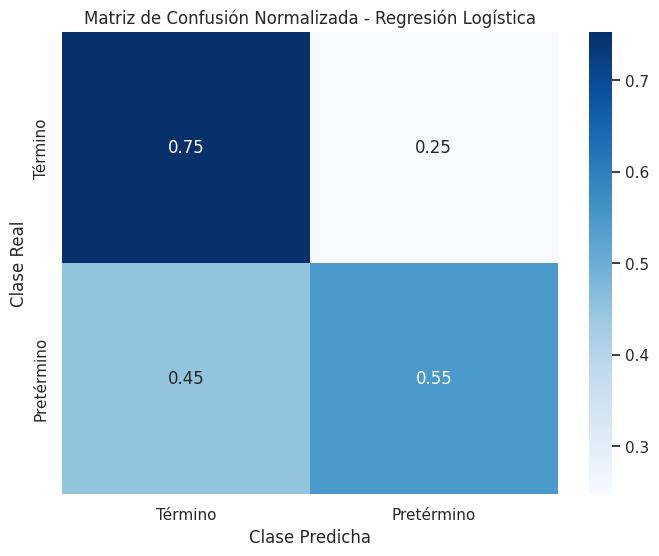

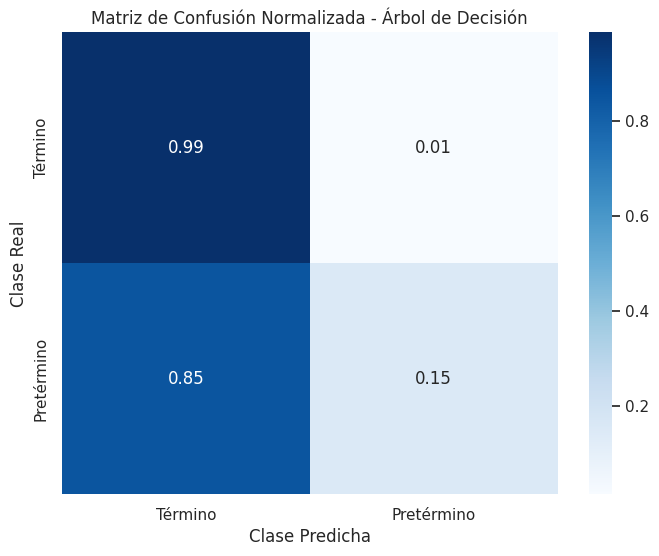

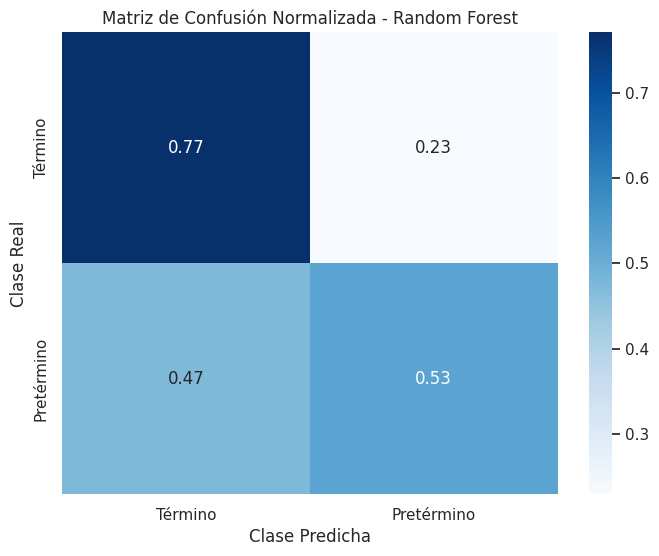

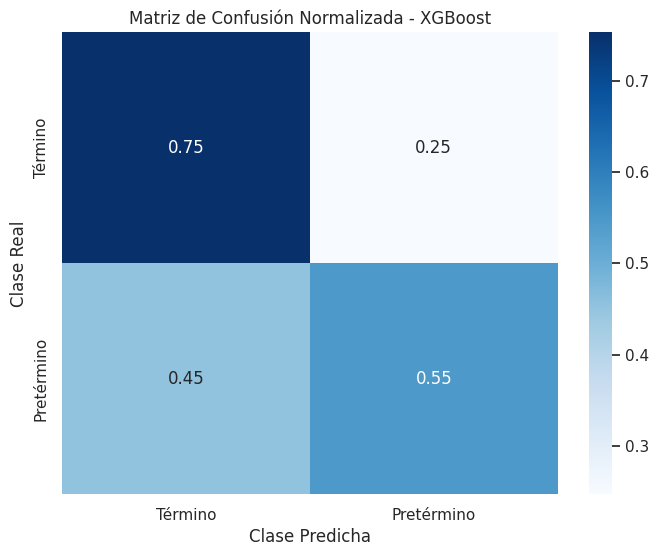

In [14]:
# Función para visualizar la matriz de confusión normalizada
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=
     ['Término', 'Pretérmino'], yticklabels=['Término', 'Pretérmino'])
    plt.title(f'Matriz de Confusión Normalizada - {model_name}')
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()

# Matrices de confusión normalizadas para cada modelo
plot_confusion_matrix(y_test, y_pred_logreg, 'Regresión Logística')
plot_confusion_matrix(y_test, y_pred_arbol, 'Árbol de Decisión')
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest')
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost')

# 6. MEJORA DEL MODEO XG BOOST


### 6.1. Ajuste de hiperparámetros

In [15]:
# Ajustar los hiperparámetros
modelo_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    random_state=42,
    scale_pos_weight=pos_weight
)

# Entrenar el modelo
modelo_xgb.fit(X_train, y_train)

# Realizar predicciones
y_pred_xgb = modelo_xgb.predict(X_test)
y_prob_xgb = modelo_xgb.predict_proba(X_test)[:, 1]

# Evaluar el modelo
print("\nModelo: XGBoost Mejorado")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_xgb))
print("\nAUC-ROC:", roc_auc_score(y_test, y_prob_xgb))


Modelo: XGBoost Mejorado
Matriz de confusión:
 [[709688 238796]
 [ 58274  73930]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.92      0.75      0.83    948484
         1.0       0.24      0.56      0.33    132204

    accuracy                           0.73   1080688
   macro avg       0.58      0.65      0.58   1080688
weighted avg       0.84      0.73      0.77   1080688


AUC-ROC: 0.7083672053889618


### 6.2. Ajuste del umbral de clasificación

In [16]:
# Definición de una lista de umbrales a probar (para elegir el más conveniente)
umbrales = [0.2, 0.3, 0.4, 0.5]

# Iterar sobre los diferentes umbrales
for umbral in umbrales:
    y_pred_xgb_ajustado = (y_prob_xgb >= umbral).astype(int)

    # Evaluar el modelo con el umbral ajustado
    print(f'\nModelo: XGBoost con Umbral Ajustado ({umbral})')
    print('Matriz de confusión:\n', confusion_matrix(y_test, y_pred_xgb_ajustado))
    print('\nReporte de clasificación:\n', classification_report(y_test, y_pred_xgb_ajustado))
    print('\nAUC-ROC:', roc_auc_score(y_test, y_prob_xgb))


Modelo: XGBoost con Umbral Ajustado (0.2)
Matriz de confusión:
 [[   948 947536]
 [    38 132166]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.96      0.00      0.00    948484
         1.0       0.12      1.00      0.22    132204

    accuracy                           0.12   1080688
   macro avg       0.54      0.50      0.11   1080688
weighted avg       0.86      0.12      0.03   1080688


AUC-ROC: 0.7083672053889618

Modelo: XGBoost con Umbral Ajustado (0.3)
Matriz de confusión:
 [[143681 804803]
 [  7584 124620]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.95      0.15      0.26    948484
         1.0       0.13      0.94      0.23    132204

    accuracy                           0.25   1080688
   macro avg       0.54      0.55      0.25   1080688
weighted avg       0.85      0.25      0.26   1080688


AUC-ROC: 0.7083672053889618

Modelo: XGBoost con Umbral Ajus

### 6.3. Validación cruzada

In [17]:
scores = cross_val_score(modelo_xgb, X_train, y_train, cv=5, scoring="accuracy")
print(f"Precisión media en validación cruzada: {scores.mean()}")

Precisión media en validación cruzada: 0.7265194191794512


## 7. INTERPRETACIÓN DEL MODELO XGBOOST

### 7.1. Importancia de variables: Factores más relacionados con el parto prete´rmino

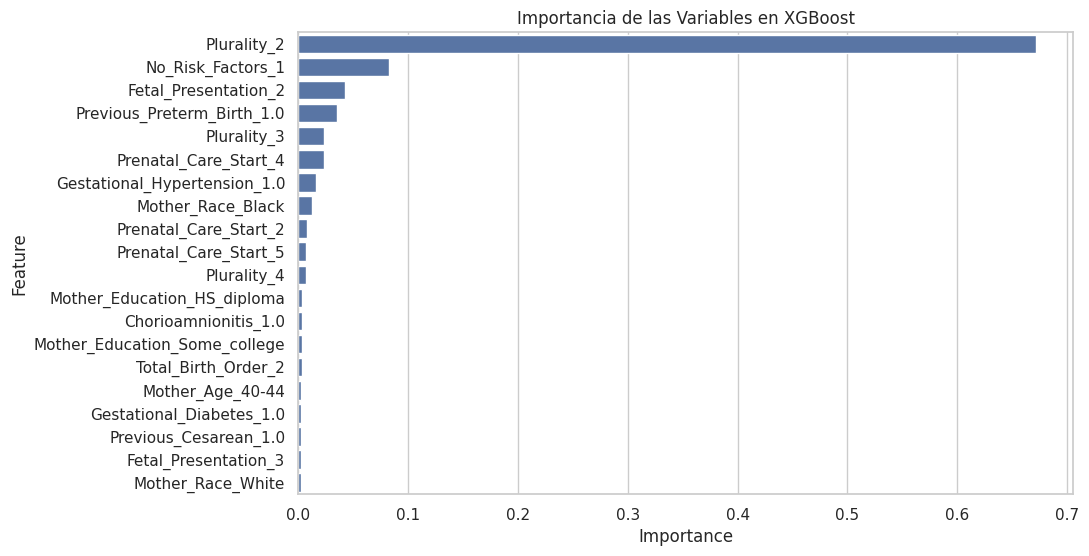

In [18]:
importances = modelo_xgb.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Importancia de las Variables en XGBoost')
plt.show()

## 8. GENERAR EL MODELO PARA SU USO

In [19]:
joblib.dump(modelo_xgb, 'modelo_xgboost_parto_prematuro.pkl')

['modelo_xgboost_parto_prematuro.pkl']